### Train and Test 

In [2]:

# import MAE
from sklearn import metrics

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# use test_train_split from sklearn
from sklearn.model_selection import train_test_split
import csv
# import solar_data.csv use a single column and store each value in a row
solar_dataset = []
# read values as float
with open('solar_data.csv', 'r') as f:
    reader = csv.reader(f)
    solar_dataset = list(reader)
    
    
solar_dataset = np.array(solar_dataset).astype(float)


In [27]:
# plot solar_dataset




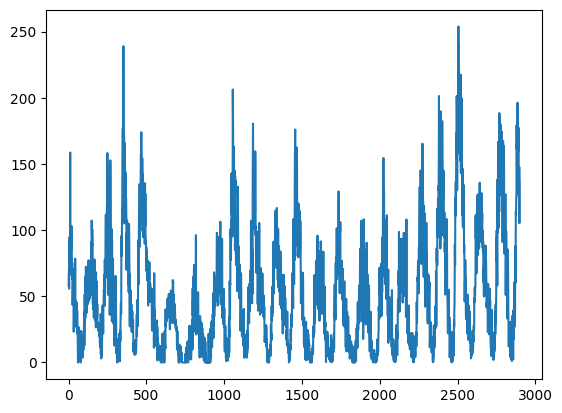

In [5]:
for i in range(0, len(solar_dataset)):
    plt.plot(solar_dataset[i])
        
plt.show()

In [6]:
# Split in train and test 
offset = 1
#first 2398 are for training
input_dataset = solar_dataset[:,:-offset]
#X = solar_dataset[0][0:2398]
#test = solar_dataset[0][2398:]
target_data = solar_dataset[:,offset:]



### Split avaiable data

In [7]:
input_training, input_test = input_dataset[0][:2398], input_dataset[0][2398:] 



In [17]:

# Divide data in train, valid, test
#train_data, test_data = train_test_split(solar_data, test_size=0.2, random_state=42)

# Divide train data in train and valid
#train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)


In [8]:
def modified_lsm(input):
    # Excitatory neurons    Inhibitory neurons
    
    #NOTE Ne is excitatory units and Ni is inhibitory units
    #NOTE a,b,c,d are parameters for those units
    Ne = 800
    Ni = 200
    re = np.random.rand(Ne)
    ri = np.random.rand(Ni)
    a = np.concatenate((0.02*np.ones(Ne), 0.02+0.08*ri))
    b = np.concatenate((0.2*np.ones(Ne), 0.25-0.05*ri))
    c = np.concatenate((-65+15*re**2, -65*np.ones(Ni)))
    d = np.concatenate((8-6*re**2, 2*np.ones(Ni)))

    #NOTE Inputs that comes from other neurons, matrix U project input into the "pull of neurons" in the mateix U we have random weights
    #NOTE So matrix U doens't learn just project in a lower space
    
    #NOTE Matrix S couples the neurons with each others
    
    # scaling of input connections
    win_e = 5
    win_i = 2
    U = np.concatenate((win_e*np.ones(Ne), win_i*np.ones(Ni)))

    # scaling of recurrent connections
    w_e = 0.5
    w_i = 1
    S = np.concatenate((w_e*np.random.rand(Ne+Ni, Ne), -w_i*np.random.rand(Ne+Ni, Ni)), axis=1)

    v = -65*np.ones(Ne+Ni)  # Initial values of v
    u = b*v  # Initial values of u
    firings = []  # spike timings
    states = []  # here we construct the matrix of reservoir states

    for t in range(len(input)):  # simulation of 1000 ms
        # we don't need random thalamic input:
        # I = np.concatenate((5*np.random.randn(Ne), 2*np.random.randn(Ni)))  # thalamic input
        # we use instead the input from the external time series!
        I = input[t] * U
        fired = np.where(v >= 30)[0]  # indices of spikes
        firings.append(np.column_stack((t+np.zeros_like(fired), fired)))
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]
        
        #NOTE Here we select the neurons that are firing (S contains connection from a neuron to any other neuron)
        #NOTE There is a pull of different neurons (some noise that makes neurons a little diverse from each other)
        
        
        I = I + np.sum(S[:, fired], axis=1)
        v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # step 0.5 ms
        v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
        u = u + a*(b*v - u)
        
        #NOTE State can be anything (like a firing rate)
        states.append(v >= 30)

    firings = np.concatenate(firings)
    plt.plot(firings[:, 0], firings[:, 1], '.')

    # in the end states is 1000 x number of time steps
    return states, firings

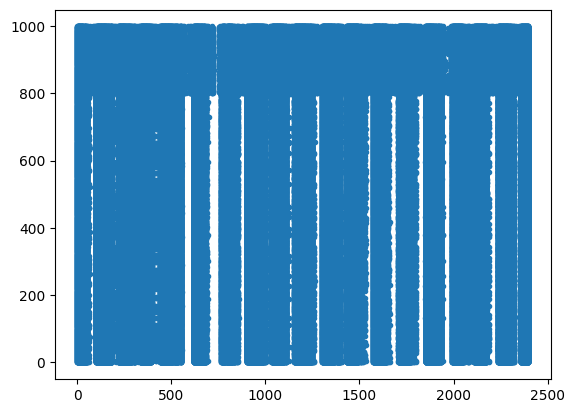

In [23]:
#plt.figure(figsize=[15,10])
input_data = input_training
#input_data = np.random.rand(10000)  # Replace with your input data
states, firings = modified_lsm(input_data)


# Readout 

In [24]:
state_mat = np.array(states).T

In [25]:
#train readout
# convert to array
Wout = input_training @ np.linalg.pinv(state_mat)

trainOutput = Wout @ state_mat



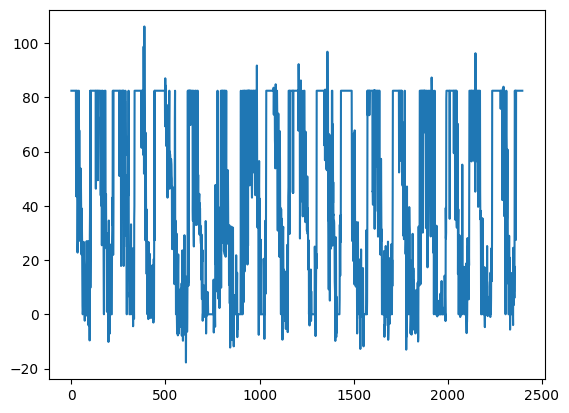

In [26]:
#plot all the train output

plt.plot(trainOutput)


# Compute MAE against training

In [27]:
# compute mae of X and trainOutput

metrics.mean_absolute_error(trainOutput, input_data)
#metrics.mean_absolute_error(predicted, test)

14.190519566987792